# Load Data and Compare Transcriptions

In [1]:
##IMPORTS#######

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import quail
import pickle
import scipy
import scipy.stats
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from itertools import groupby
from collections import OrderedDict

/Users/campbellfield/anaconda/lib/python2.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
#get names of all files (subject names) we want lists from
filenames = []
for f in os.listdir('../data/Google/'):
    if f != '.DS_Store':
        filenames.append(f)

In [3]:
#load in egg with all words presented
egg = pickle.load(open('../data/eggAuto4.p', 'rb'))

#get subject ids
filenames = egg.meta['ids']
#add the two sub ids missing from the meta data
filenames.append(u'debugZANF1E:debugNSAB89')
filenames.append(u'debugQVC5IH:debugWA2XJU')

In [4]:
#make a dictionary to organize info from transcription comparison
transcription_dict = {}
types = ['man', 'auto'] #manual and automatic transcriptions
    
for typ in types:
        
    #create a dictionary for each type of transcription
    transcription_dict['%s' % typ] = {}
    
    #organize info into lists
    transcription_dict['%s' % typ]['all_lists_back_counter'] = []
    transcription_dict['%s' % typ]['all_num_words_recalled'] = []
    transcription_dict['%s' % typ]['all_error_external'] = []
    
#store paths to correct transcription folder
transcription_dict['man']['path'] = ['../data/PennTotalRecall/']
transcription_dict['auto']['path'] = ['../data/Google/']

In [5]:
#compare manual and automatic transcriptions for each subject
for typ in types:

    for idx, subject in enumerate(filenames):
    
        #get subject directory
        folder = transcription_dict['%s' % typ]['path'][0] + subject  
    
        #these lists will contain a value for each word list, all organized in sub_dict
        sub_dict = {}
        sub_dict['lists_back_counter_%s' % typ] = [0, 0, 0, 0, 0, 0, 0, 0]
        sub_dict['num_words_recalled_list_%s' % typ] = []
        sub_dict['prop_error_external_list_%s' % typ] = []
        sub_dict['all_presented'] = []
        
        #for the first 8 lists, compare man and auto transcriptions for each
        for x in range(0,8):

            list_num = x
            #get path for file
            transcription_dict['man']['filename'] = 'new' + subject + '-' + str(x) + '.ann'
            transcription_dict['auto']['filename'] = subject + '-' + str(x)+ '.wav.txt'
            #get list of words for each transcription
            sub_dict['%s' % typ] = []
            
            #change into subject directory and load transcription files
            os.chdir(folder)
            transcription = open(transcription_dict['%s' % typ]['filename'])
            
            #for manual transcriptions:
            if typ == 'man':
                transcription_contents = transcription.read().split('\n')
                for line in transcription_contents:
                    word = line.split('\t')
                    if word[0] != '':
                        sub_dict['%s' %typ].append(word[2])
                    transcription.close()
            
            #for automatic transcriptions
            if typ == 'auto':
                transcription_contents = transcription.read().split('\n')
                for line in transcription_contents:
                    word = line.split(',')
                    if word[0] != '':
                        sub_dict['%s' % typ].append(word[0])
                    transcription.close()
            
            os.chdir('../../')
        
            #from the egg, get list of the words that were presented in this specific list
            presented = egg.pres.loc[idx].loc[list_num].values
        
            #get number of words recalled in the transcription
            sub_dict['num_words_recalled_%s' % typ] = float(len(sub_dict['%s' % typ]))
        
            #check for errors and see if they match any words not previously presented (external errors)
            sub_dict['match_external_%s' % typ] = 0
        
            #check for errors in manually transcribed list
            for x in sub_dict['%s' % typ]:
                #if the word was presented in the current list, it's not an error
                if x in presented:
                    pass
                #for every word that is recalled in MAN but wasn't presented, count in match_external
                else:
                    sub_dict['match_external_%s' % typ] += 1
                
                #if word was recalled from a previous list, add one to the index of list_back_counter
                #for example, a one-back error would add one to list_back_counter[1]
                for idxcounterman, words in enumerate(sub_dict['all_presented'], start = 0):
                    if x in words:
                        lists_back = (len(sub_dict['all_presented']) + 1) - (idxcounterman+1)
                        sub_dict['lists_back_counter_%s' % typ][lists_back] += 1.0 #num at index is num errors made that index lists back
            
            #get proportion of all words recalled from this list that are external errors
            sub_dict['prop_error_external_%s' % typ] = float(sub_dict['match_external_%s' % typ])/float(len(sub_dict['%s' % typ]))
            #add that proportion to list of external error proportions for the subject
            sub_dict['prop_error_external_list_%s' % typ].append(sub_dict['prop_error_external_%s' % typ])
        
            #add number of words recalled in this list to list for subject
            #this will have one value for each list that represents the total number of words that were transcribed
            sub_dict['num_words_recalled_list_%s' % typ].append(sub_dict['num_words_recalled_%s' % typ])
        
            #add words presented in this list to list of all words that have been presented to the subject so far
            #this is a list of all word lists subject has seen
            sub_dict['all_presented'].append(presented) 

        
        #append this individual's concatenated lists to the list of all subjects
        transcription_dict['%s' % typ]['all_error_external'].append(np.array(sub_dict['prop_error_external_list_%s' % typ]))
        
        transcription_dict['%s' % typ]['all_lists_back_counter'].append(sub_dict['lists_back_counter_%s' % typ])
        
        transcription_dict['%s' % typ]['all_num_words_recalled'].append(sub_dict['num_words_recalled_list_%s' % typ])
        

# Prior list intrusions

 - Get number of previous list errors for each subject, man and auto
 - Get proportion of words recalled that were previous list errors
 - Sort proportions into corresponding "-back error lists"

In [6]:
#make a dictionary to organize info for each list back
lists_back = ['one_back', 'two_back', 'three_back', 'four_back', 'five_back', 'six_back']

list_back_dict = OrderedDict((list_back, {}) for list_back in lists_back)

#organize spots for all info
for list_back in lists_back:
    
    #get info for manual and automatic transcriptions
    for typ in types:
        
        #make a list of previous list errors
        list_back_dict['%s' % list_back]['errors_%s' % typ] = []   
        
        #sort proportions into corresponding "-back error" lists
        list_back_dict['%s' % list_back]['error_props_%s' % typ] = []

In [7]:
#organize info for list-back dictionaries
for list_back in lists_back:
    
    for typ in types:

        #for each subject, add the number of previous list errors to the corresponding list-back entry
        for subject in transcription_dict['%s' % typ]['all_lists_back_counter']:

            for i, (list_back, list_dict) in enumerate(list_back_dict.items()):
                
                #add number of previous list errors
                list_back_dict[list_back]['errors_%s' % typ].append(subject[i+1])             

In [8]:
#make a list of proportion recalled that were previous list errors
for typ in types:
    
    transcription_dict['%s' % typ]['prev_list_error_props'] = []

In [9]:
#get proportion of previous list errors, one list for each subject
for typ in types:

    for idx, subject in enumerate(transcription_dict['%s' % typ]['all_lists_back_counter'], start = 0):
        
        list_back_errors = subject
        total_recalled_in_list = transcription_dict['%s' % typ]['all_num_words_recalled'][idx]
        prop_list = np.divide(list_back_errors, total_recalled_in_list)
        transcription_dict['%s' % typ]['prev_list_error_props'].append(prop_list)

In [10]:
#add proportion of previous list errors to list-back dictionaries
for typ in types:
    
    for list_back in lists_back:

        for subject in transcription_dict['%s' % typ]['prev_list_error_props']: 
        
            list_back_dict[list_back]['error_props_%s' % typ].append(subject[lists_back.index(list_back) + 1]) 

#### Create data frame for each list back
Each data frame includes:
- subject number
- normalized prev list error proportion
- transcription type (man or auto)

In [11]:
#organize info
for typ in types:
    
    transcription_dict['%s' % typ]['avg_prev_errors'] = []
    
for list_back in lists_back:
    
    list_back_dict[list_back]['data'] = []

In [12]:
#create data frame for each list back
##this works for one-back, but two-back is double what it should be, three-back is 3x what it should be, etc.??
for typ in types:

    for list_back in lists_back:
        
        #collect data
        for i in range(0, 30):

            prop = float(list_back_dict['%s' % list_back]['error_props_%s' % typ][i])/16
            list_back_dict['%s' % list_back]['data'].append({'Subject': i, 'Proportion of Total Possible Errors' : prop, 'Transcription Type' : '%s' % typ})
        
        #put it into a data frame
        list_back_dict['%s' % list_back]['df'] = pd.DataFrame(list_back_dict['%s' % list_back]['data'])
        df = list_back_dict['%s' % list_back]['df']
    
        #get averages for each
        transcription_dict['%s' % typ]['avg_prev_errors'].append(sum(df[df['Transcription Type']=='%s' % typ]['Proportion of Total Possible Errors'])/30)

In [13]:
#this is comparing avg prev errors in transcription dict to the values from the orginal notebook we used
print transcription_dict['man']['avg_prev_errors']
print [0.0032854905511155511, 0.00079737103174603175, 0.00019364316239316241, 0.0, 4.6296296296296294e-05, 2.1701388888888886e-05]
print transcription_dict['auto']['avg_prev_errors']
print [0.003217284145592969, 0.00062624007936507931, 0.00020047949735449734, 0.0, 0.00010438924501424502, 2.1701388888888886e-05]

[0.0032854905511155511, 0.0015947420634920635, 0.00058092948717948718, 0.0, 0.00023148148148148146, 0.00013020833333333333]
[0.003285490551115551, 0.0007973710317460318, 0.0001936431623931624, 0.0, 4.6296296296296294e-05, 2.1701388888888886e-05]
[0.003217284145592969, 0.0012524801587301586, 0.00060143849206349199, 0.0, 0.00052194622507122502, 0.00013020833333333333]
[0.003217284145592969, 0.0006262400793650793, 0.00020047949735449734, 0.0, 0.00010438924501424502, 2.1701388888888886e-05]


In [14]:
#QUICK FIX TO MOVE ON, THESE ARE THE RIGHT VALUES BUT HAD TO CORRECT FOR THEM
#STILL DON'T KNOW WHAT ERROR IS
transcription_dict['man']['avg_prev_errors'][1] = transcription_dict['man']['avg_prev_errors'][1]/2
transcription_dict['man']['avg_prev_errors'][2] = transcription_dict['man']['avg_prev_errors'][2]/3
transcription_dict['man']['avg_prev_errors'][3] = transcription_dict['man']['avg_prev_errors'][3]/4
transcription_dict['man']['avg_prev_errors'][4] = transcription_dict['man']['avg_prev_errors'][4]/5
transcription_dict['man']['avg_prev_errors'][5] = transcription_dict['man']['avg_prev_errors'][5]/6

transcription_dict['auto']['avg_prev_errors'][1] = transcription_dict['auto']['avg_prev_errors'][1]/2
transcription_dict['auto']['avg_prev_errors'][2] = transcription_dict['auto']['avg_prev_errors'][2]/3
transcription_dict['auto']['avg_prev_errors'][3] = transcription_dict['auto']['avg_prev_errors'][3]/4
transcription_dict['auto']['avg_prev_errors'][4] = transcription_dict['auto']['avg_prev_errors'][4]/5
transcription_dict['auto']['avg_prev_errors'][5] = transcription_dict['auto']['avg_prev_errors'][5]/6

print transcription_dict['man']['avg_prev_errors']
print [0.0032854905511155511, 0.00079737103174603175, 0.00019364316239316241, 0.0, 4.6296296296296294e-05, 2.1701388888888886e-05]
print transcription_dict['auto']['avg_prev_errors']
print [0.003217284145592969, 0.00062624007936507931, 0.00020047949735449734, 0.0, 0.00010438924501424502, 2.1701388888888886e-05]

[0.0032854905511155511, 0.00079737103174603175, 0.00019364316239316238, 0.0, 4.6296296296296294e-05, 2.170138888888889e-05]
[0.003285490551115551, 0.0007973710317460318, 0.0001936431623931624, 0.0, 4.6296296296296294e-05, 2.1701388888888886e-05]
[0.003217284145592969, 0.00062624007936507931, 0.00020047949735449734, 0.0, 0.00010438924501424501, 2.170138888888889e-05]
[0.003217284145592969, 0.0006262400793650793, 0.00020047949735449734, 0.0, 0.00010438924501424502, 2.1701388888888886e-05]


#### Make grid with list-back figures

In [15]:
#organize info
for typ in types:
    
    transcription_dict['%s' % typ]['avg_prev_errors_divided'] = []
    
    for list_back in lists_back:
        
        list_back_dict[list_back]['divided_%s' % typ] = []

In [16]:
#divide by 10^-3 for prop list back errors plot
for typ in types:
    
    #divide avg previous errors
    transcription_dict['%s' % typ]['avg_prev_errors_divided'] = [x/10e-3 for x in transcription_dict['%s' % typ]['avg_prev_errors']]
    transcription_dict['%s' % typ]['avg_prev_errors_divided'] = transcription_dict['%s' % typ]['avg_prev_errors_divided']

    for list_back in lists_back:
        
        df = list_back_dict['%s' % list_back]['df']
        
        #divide proportion of list back errors
        list_back_dict[list_back]['divided_%s' % typ] = [x/10e-3 for x in list(df[df['Transcription Type']=='%s' % typ]['Proportion of Total Possible Errors'])]

In [17]:
#get error bar values
for typ in types:
    
    transcription_dict['%s' % typ]['yerr'] = []

for typ in types:
    
    for list_back in lists_back:
        
        transcription_dict['%s' % typ]['yerr'].append(np.std(list_back_dict[list_back]['divided_%s' % typ])) 

(0.94556324368722766, 3.5173899792318626e-15)
(0.8489489313912536, 3.0537524850093859e-09)
(0.99169090993724485, 1.7406855493025531e-26)
(nan, 1.0)
(0.73762884992468125, 3.3070606877086598e-06)


/Users/campbellfield/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


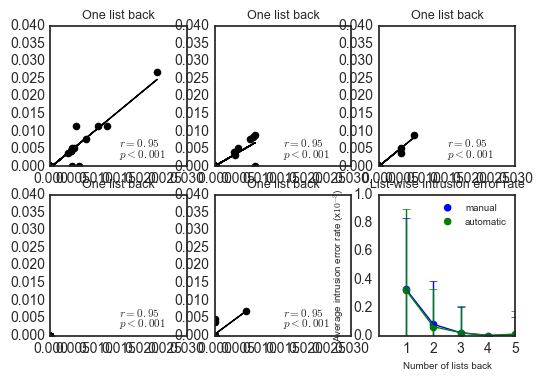

In [18]:
#set up grid of six scatter plots, one for each list-back error
#plots show man vs. auto transcription for prev list error proportions
#each point represents a subject
sns.set_style('white')

#set up the grid
fig, axs = plt.subplots(nrows=2, ncols=3)

#plot prior list errors for each list back
for i in range(0, 5):
    ax = axs.flat[i]
    
    #data
    df = list_back_dict[lists_back[i]]['df']
    man_prop_errors = df[df['Transcription Type']=='man']['Proportion of Total Possible Errors']
    auto_prop_errors = df[df['Transcription Type']=='auto']['Proportion of Total Possible Errors']
    
    #scatter plot
    ax.scatter (man_prop_errors, auto_prop_errors, color = 'black', edgecolors = 'black')  
    
    #get line of best fit
    reg_line = np.polyfit(man_prop_errors, auto_prop_errors, 1)
    reg_line_fn = np.poly1d(reg_line)
    ax.plot(man_prop_errors, reg_line_fn(man_prop_errors), color = 'black')
    
    #get R value
    r = pearsonr(man_prop_errors, auto_prop_errors)
    ax.text(0.015, 0.0055, '$r=0.95$', size = 8)
    ax.text(0.015, 0.0025, '$p<0.001$', size = 8)
    
    #set title and x and y limits
    ax.set_title('One list back', size = 9)
    ax.set_xlim(0, 0.03)
    ax.set_ylim(0, 0.04)
    
    print r

#plot p(error) by list back
ax = axs.flat[5]
ax.scatter(range(1, 7), transcription_dict['man']['avg_prev_errors_divided'], color = 'blue', label = 'manual')
ax.scatter(range(1, 7), transcription_dict['auto']['avg_prev_errors_divided'], color = 'green', label = 'automatic')
ax.errorbar(range(1,7), transcription_dict['man']['avg_prev_errors_divided'], yerr = transcription_dict['man']['yerr'],  color = 'blue')
ax.errorbar(range(1,7), transcription_dict['auto']['avg_prev_errors_divided'], yerr = transcription_dict['auto']['yerr'],  color = 'green')
ax.set_title('List-wise intrusion error rate', size = 9)

#set axes labels
ax.set_xlabel('Number of lists back', size = 7)
ax.set_ylabel('Average intrusion error rate (x$10^{-3}$)', size = 7)

#set x and y lim
ax.set_xlim(0, 5)
ax.set_ylim(0, 1)
ax.set_xticks([1,2,3,4,5])

#legend
ax.legend(loc = 'upper right', fontsize = 'x-small')
  
plt.show()

# Extra List Intrusions

In [19]:
#this list will have one average proportion for each subject's transcription
for typ in types:
    
    transcription_dict['%s' % typ]['all_error_external_avgs'] = []
    
#for typ in types:    
    #get average proportions for transcription
    for sub in transcription_dict['%s' % typ]['all_error_external']:
        avg = float(sum(sub))/float(len(sub))
        transcription_dict['%s' % typ]['all_error_external_avgs'].append(avg)

(0.61048795101385567, 0.00034018848785556492)


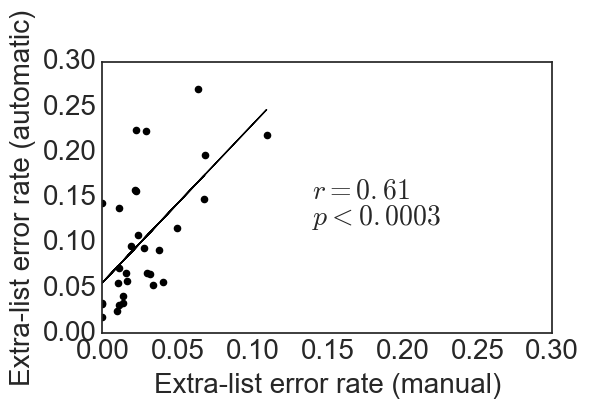

In [20]:
#plot average proportion of external errors in man vs. auto transcription on scatter plot
sns.set_style('white')
fig, ax = plt.subplots()
plt.scatter(transcription_dict['man']['all_error_external_avgs'], transcription_dict['auto']['all_error_external_avgs'], color = 'black', edgecolors = 'black')

#label axes
ax.set_xlabel('Extra-list error rate (manual)', size = 20)
ax.set_ylabel('Extra-list error rate (automatic)', size = 20)
plt.tick_params(labelsize=20)
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)

#get line of best fit
reg_line = np.polyfit(transcription_dict['man']['all_error_external_avgs'], transcription_dict['auto']['all_error_external_avgs'], 1)
reg_line_fn = np.poly1d(reg_line)
plt.plot(transcription_dict['man']['all_error_external_avgs'], reg_line_fn(transcription_dict['man']['all_error_external_avgs']), color = 'black')

#get R value
r = pearsonr(transcription_dict['man']['all_error_external_avgs'], transcription_dict['auto']['all_error_external_avgs'])
plt.text(0.14, 0.15, '$r = 0.61$', size = 20)
plt.text(0.14, 0.12, '$p < 0.0003$', size = 20)
print r

#save plot and show
plt.tight_layout()
plt.style.use('default')
plt.savefig('../AutoFR-figures/extralistintrusionerrors.pdf', bbox_inches = 'tight')
plt.show()